# EP Tender : simulation par chaînes de Markov

## Description du modèle

On considère une station comportant $f$ files, pour un total de $N$ tenders en circulation. Chaque tender comporte $d + 1$ états de charge, numérotés de 0 à $d$. À 0 un tender est complètement déchargé, et à $d$ il est complètement chargé.

On utilise un modèle à temps discret.

Les voitures clientes arrivent de sorte que l'écart temporel entre la $i$-ième voiture et la $(i+1)$-ième est de loi géométrique de paramètre $\lambda$. Lorsqu'elles arrivent elles doivent prendre un tender complètement chargé qu'elles ramènent complètement déchargé au début de l'étape suivante.

Fatalement, un jour plus de $N$ voitures arriveront en même temps et alors la demande ne pourra pas être satisfaite. On note $T_\mathrm{bug}$ le premier temps où la demande en Tender est insatisfaite et on s'intéresse à son espérance. On cherche à trouver, pour un processus de rangement et de sélection des tenders donné, l'espérance de $T_\mathrm{bug}$, qu'on souhaite maximal.

Chaque étape temporelle se déroule comme suit :
1. Tous les tenders dans la station gagnent un niveau de charge, pour un niveau maximum de $d$.
2. Les tenders partis à l'étape précédente sont rangés dans la station.
3. Les nouvelles voitures clientes arrivent et des tenders chargés leur sont attribués.
4. Si la demande a pu être satisfaite, on passe au temps suivant.

## Importation des modules

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

## Encodage des états de la station

On remarque tout d'abord qu'on ne peut accéder aux tenders les plus loins dans une file qu'une fois le premier tender parti : il devra donc avoir été entièrement rechargé, et tous ceux arrivés antérieurement le seront de même. Les seules informations pertinentes pour une file sont donc le nombre de tenders présents, et le niveau de charge du plus récemment arrivé.  
  
On encodera donc dans la suite les stations sous la forme de matrice de taille $f \times 2$, où la première colonne désigne le nombre de tenders dans chaque station et la seconde colonne le niveau de charge du tender le plus récemment arrivé pour chaque file.  
Comme on peut permuter les files sans affecter la capacité à servir la demande, on se restreint aux états pour lesquels les files sont de longueurs décroissantes (et, au sein des files de même longueur, de niveau de charge décroissant).

## Charge des tenders

L'algorithme de charge s'écrit simplement dans le cas où les files chargent tous les tenders en même temps.

In [ ]:
def chargeSimplifie(station, d) :
    # Renvoie la même station simplifiée après que tous les tenders aient été chargés de 1
    
    station = station.copy()
        
    for i in range(station.shape[0]) :
        if station[i, 0] != 0 and station[i, 1] != d :
            station[i, 1] += 1
    
    return station

## Liste des stations

On peut désormais lister l'ensemble des états possibles pour les stations.

### Parcours d'ensembles de suite dans l'ordre lexicographique décroissant

Dans la suite, nous allons avoir besoin de fonctions élémentaires permettant de parcourir, dans l'ordre lexicographique décroissant, l'ensemble des suites vérifiant des contraintes données.

In [ ]:
def suiteSuivanteDecSumCst(l) :
    # Permet de parcourir l'ensemble des suites décroissantes de longueur et somme données, selon l'ordre lexicographique
    # décroissant. Renvoie False quand on a atteint le dernier état.
    
    l = l.copy()
    i = len(l) - 1
    curSum = 1
    
    while i >= 0 and curSum > (l[i] - 1) * (len(l) - 1 - i):
        curSum += l[i]
        i -= 1
    
    if i >= 0 :
        l[i] -= 1
        j = i + 1
        while curSum > 0 :
            l[j] = min([curSum, l[i]])
            curSum -= l[j]
            j += 1
        while j < len(l) :
            l[j] = 0
            j += 1
    else :
        l = False
    
    return l    

### D'un état à l'autre, avec les tailles de file fixées

In [ ]:
def etatSimplifieSuivant(station, d) :
    # Passe d'un état simplifié à l'autre, à nombre de tenders par file donné, selon
    # l'ordre lexicographique décroissant pour les niveaux de charge
    
    station = station.copy()
    
    curFile = station.shape[0] - 1
    
    while curFile >= 0 :
        if station[curFile, 1] >= 1 :
            station[curFile, 1] -= 1
            j = curFile + 1
            while j < station.shape[0] and station[curFile, 0] == station[j, 0] :
                station[j, 1] = station[curFile, 1]
                j += 1
            break
        elif station[curFile, 0] != 0 :
            station[curFile, 1] = d
        curFile -= 1
        
    if curFile == -1 :
        station = False
    
    return station

### D'un état à l'autre

In [ ]:
def stationSimplifieeSuivante(station, d) :
    # Permet de parcourir l'ensemble des états possibles pour une station sous forme
    # simplifiee avec un nombre donné de tenders, sans répéter deux états équivalents.
    # Parcourt la répartition des tenders par file selon l'ordre lexicographique
    # décroissant.
    
    station = station.copy()
    
    if type(etatSimplifieSuivant(station, d)) != bool :
        station = etatSimplifieSuivant(station, d)
    else :
        tenderParFile = station[:, 0]
        if type(suiteSuivanteDecSumCst(tenderParFile)) == bool :
            station = False
        else :
            tenderParFile = suiteSuivanteDecSumCst(tenderParFile)
            station[:, 0] = tenderParFile
            for i in range(station.shape[0]) :
                if tenderParFile[i] != 0 :
                    station[i, 1] = d
                else :
                    station[i, 1] = 0
    
    return station

### Liste des stations

In [ ]:
def listAllStations(nTenders, nFiles, d) :
    
    listStations = []
    
    station = np.zeros([nFiles, 2])
    station[0, 0] = nTenders
    station[0, 1] = d

    while type(station) != bool :
        listStations.append(station)
        station = stationSimplifieeSuivante(station, d)
    
    listStations.append(False) # Indique erreur
    
    return listStations

In [ ]:
listAllStations(2, 3, 1)

In [ ]:
listAllStations(4, 2, 2)

## Rangement d'une station désordonnée

Le rangement de tenders dans une file peut conduire la station à ne plus avoir ses files dans l'ordre décroissant. Il faut donc être capable de remettre la station dans l'ordre.

In [ ]:
def rangeStationSimplifiee(station) :
    
    station = station.copy()
    
    maxCharge = max(station[:, 1])
    sortingTable = (maxCharge + 1) * station[:, 0] + station[:, 1]
    
    newIndices = np.argsort(sortingTable)
    
    station = station[newIndices[::-1], :]
    
    return station

## Algorithmes de décision

Il nous faut maintenant décider des algorithmes de décision pour le rangement et l'attribution des tenders. On peut modéliser ces algorithmes par des fonctions $f$ qui prennent en entrée l'état de la station, $S$, et renvoient $f(S)$, l'état de la station après y avoir ajouté le tender déchargé. Plusieurs tenders peuvent arriver en même temps, avec notre modèle, on devrait donc avoir une fonction $f(S, k)$ où $k$ est le nombre de tenders qui arrivent à une étape temporelle donnée, et la valeur prise est l'état de la station après y avoir rangé tous les tenders. Cependant, en pratique, on ne voit arriver qu'une voiture à la fois, et on n'anticipe pas quand les prochaines voitures arriveront, on décide donc de manière itérative : $f(f(S, k), 1) = f(S, k + 1)$ et on n'a donc besoin de connaître que $f(S) = f(S, 1)$.

### Algorithme glouton

On code ici l'algorithme glouton détaillé dans le rapport.

In [ ]:
def rangementGloutonSimplifie(station) :
    
    station = station.copy()
    
    curFile = station.shape[0] - 1
    
    if station[curFile, 0] == 0 :
        station[curFile, 0] += 1
    else :
        minCharge = min(station[:(curFile+1), 1])
        while station[curFile, 1] != minCharge :
            curFile -= 1
        station[curFile, 1] = 0
        station[curFile, 0] += 1
        
    station = rangeStationSimplifiee(station)
    
    return station

In [ ]:
def donGloutonSimplifie(station, d) :
    
    station = station.copy()
    
    curFile = station.shape[0] - 1
    
    while curFile >= 0 and station[curFile, 1] != d :
        curFile -= 1
    
    if curFile == -1 :
        station = False
    else :
        station[curFile, 0] -= 1
        if station[curFile, 0] == 0 :
            station[curFile, 1] = 0
    
        station = rangeStationSimplifiee(station)
    
    return station

### Algorithmes basés sur un indice

On code ici l'algorithme basé sur une classe d'indice, comme détaillé dans la section 6 du rapport. Le choix de la file d'où l'on extrait les tenders reste le même que pour l'algorithme glouton, car ce choix est optimal.

In [ ]:
def rangementIndiceSimplifie(station, indice) :
    
    station = station.copy()
    
    fileRangement = np.argmin([indice(station[station.shape[0] - 1 - i, :]) for i in range(station.shape[0])])
    station[station.shape[0] - 1 - fileRangement, 0] += 1
    station[station.shape[0] - 1 - fileRangement, 1] = 0
        
    station = rangeStationSimplifiee(station)
    
    return station

### Indices

In [ ]:
def indiceLineaire(file, lbd) :
    return lbd * file[1] + file[0]

In [ ]:
def indiceLogarithmique(file, lbd) :
    if file[0] != 0 and file[1] != 0 : 
        v = np.log(lbd) * file[1] + np.log(file[0])
    else :
        v = - np.inf
    return v

In [ ]:
def indiceMultiplicatif(file, lbd) :
    return file[1] * file[0]**lbd

In [ ]:
def indiceMultiplicatifCorr(file, lbd, d) :
    if file[1] == d :
        return np.inf
    else :
        return file[0]**lbd / (d - file[1])

In [ ]:
def indicePuis(file, lbd, mu) :
    return file[1]**lbd + mu * file[0]

In [882]:
def indicePuisCorr(file, lbd, mu, d) :
    return mu * file[0] - (d - file[1]) ** lbd

In [880]:
def indicePuisLog(file, lbd, mu) :
    if file[0] == 0 :
        return - np.inf
    else :
        return file[1]**lbd + mu * np.log(file[0])

In [881]:
def indicePuisLogCorr(file, lbd, mu, d) :
    if file[0] == 0 :
        return - np.inf
    else :
        return mu * np.log(file[0]) - (d - file[1])**lbd

## Création de la matrice de transition

Pour rappel, l'écart entre la date d'arrivée de la $i$-ième voiture et celle de la $(i+1)$-ième suit une loi géométrique de paramètre $\lambda$. Pour simplifier, on change (de manière équivalente) le déroulement de chaque étape temporelle comme suit :
1. Les nouvelles voitures clientes arrivent et des tenders chargés leur sont attribués.
2. Tous les tenders dans la station gagnent un niveau de charge, pour un niveau maximum de $d$.
3. Les tenders partis reviennent et sont rangés dans la station.
4. Si la demande a pu être satisfaite, on passe au temps suivant.

Pour obtenir une chaîne de Markov irréductible, on crée un nouvel état, False, qui dénote que la demande n'a pas pu être satisfaite, et à partir de cet état on repart vers un état arbitraire. On cherche donc le temps moyen pour atteindre False.

In [ ]:
rng = np.random.default_rng(1964)

In [ ]:
def createTransitionMatrix(listeEtat, ajout, retrait, charge, theta) :
    
    transitionMatrix = np.zeros([len(listeEtat)] * 2)
    
    for i in range(len(listeEtat) - 1) :
        curStation = listeEtat[i]
        nClients = 0
        curProb = 1 - theta
        
        while type(curStation) != bool :
            ghostStation = charge(curStation)
            for k in range(nClients) :
                ghostStation = ajout(ghostStation)
            j = 0
            while not (listeEtat[j] == ghostStation).all() :
                j += 1
            transitionMatrix[i, j] += curProb # Même si on reviendra pas deux fois au même état
            curProb *= theta
            nClients += 1
            curStation = retrait(curStation)
        
        transitionMatrix[i, len(listeEtat) - 1] = 1 - np.sum(transitionMatrix[i, :])
    
    transitionMatrix[len(listeEtat) - 1, :] = 1 / len(listeEtat)
        
    return transitionMatrix

In [ ]:
def expectedHittingTime(M, i, j) :
    # Returns expected hitting time from i to j using transition matrix M
    
    M = M.copy()
    M[j, :] = 0
    
    b = np.array([1] * M.shape[0])
    b[j] = 0
    
    v = np.linalg.solve(np.identity(M.shape[0]) - M, b)
    
    return v[i], v

In [ ]:
def plotExpectedHittingTime(nTenders, nFiles, nCharge, ajout, retrait, charge, res = 0.05, etatDepart = None, etatArrivee = None) :
    
    if type(etatDepart) != np.ndarray :
        etatDepart = [[(nTenders // (nFiles - 1)) + 1, nCharge]] * (nTenders % (nFiles - 1))
        etatDepart += [[(nTenders // (nFiles - 1)), nCharge]] * (nFiles - 1 - (nTenders % (nFiles - 1)))
        etatDepart += [[0, 0]]
        etatDepart = np.array(etatDepart)
    
    if type(etatArrivee) != np.ndarray :
        etatArrivee = False
    
    
    listeEtat = listAllStations(nTenders, nFiles, nCharge)    
    ajout = rangementGloutonSimplifie
    retraitBis = lambda x : retrait(x, nCharge)
    chargeBis = lambda x : chargeSimplifie(x, nCharge)
    
    i = 0
    j = 0
    
    while not np.array(listeEtat[i] == etatDepart).all() :
        i += 1
    
    while not np.array(listeEtat[j] == etatArrivee).all() :
        j += 1
    
    
    thetaArray = np.arange(res, 1, res)
    expectedHittingTimes = []
    
    for theta in thetaArray :
        M = createTransitionMatrix(listeEtat, ajout, retraitBis, chargeBis, theta)
        expectedHittingTimes.append(expectedHittingTime(M, i, j)[0])

    return thetaArray, expectedHittingTimes

## Graphiques

### Graphiques gloutons

In [ ]:
fig = plt.figure()
ax = fig.add_axes(rect = [0.05, 0.05, 0.95, 0.95])

ax.plot(thetaArray, expectedHittingTimes, color = blue)
ax.set_ylim([0, 50])

In [ ]:
thetaArray, expectedHittingTimes = plotExpectedHittingTime(4, 2, 2, rangementGloutonSimplifie, donGloutonSimplifie, chargeSimplifie, res = 0.01, etatDepart = etatDepart)

In [ ]:
fig = plt.figure()
ax = fig.add_axes(rect = [0.05, 0.05, 0.95, 0.95])
Y = []

for nFile in [2, 3, 4] :
    thetaArray, expectedHittingTimes = plotExpectedHittingTime(6, nFile, 2, rangementGloutonSimplifie, donGloutonSimplifie, chargeSimplifie, res = 0.1)
    Y.append(expectedHittingTimes)
    print(nFile)
    
ax.plot(thetaArray, np.array(Y).transpose())
ax.set_ylim([0, 50])
ax.legend(['2 files', '3 files', '4 files'])
ax.set_title('6 tenders, 2 niveaux de charge')
plt.show()

### Graphiques pour indice linéaire

In [ ]:
nTenders = 20
nFiles = 3
d = 2
listeEtat = listAllStations(nTenders, nFiles, d)
ajout = rangementGloutonSimplifie
retrait = lambda x : donGloutonSimplifie(x, d)
charge = lambda x : chargeSimplifie(x, d)
theta = 5/6

M = createTransitionMatrix(listeEtat, ajout, retrait, charge, theta)

etatDepart = [[(nTenders // (nFiles - 1)) + 1, nCharge]] * (nTenders % (nFiles - 1))
etatDepart += [[(nTenders // (nFiles - 1)), nCharge]] * (nFiles - 1 - (nTenders % (nFiles - 1)))
etatDepart += [[0, 0]]
etatDepart = np.array(etatDepart)

etatArrivee = False

i = 0
j = 0

while not np.array(listeEtat[i] == etatDepart).all() :
    i += 1

while not np.array(listeEtat[j] == etatArrivee).all() :
    j += 1

v, _ = expectedHittingTime(M, i, j)

print(v)

In [ ]:
nTenders = 20
nFiles = 3
d = 2
listeEtat = listAllStations(nTenders, nFiles, d)
retrait = lambda x : donGloutonSimplifie(x, d)
charge = lambda x : chargeSimplifie(x, d)
theta = 5/6

lbdArray = np.arange(1, 10 + 0.25, 0.25)
tabTErr = []

for lbd in lbdArray :
    indice = lambda x : indiceLineaire(x, lbd)
    ajout = lambda x : rangementIndiceSimplifie(x, indice)
    M = createTransitionMatrix(listeEtat, ajout, retrait, charge, theta)
    
    etatDepart = [[(nTenders // (nFiles - 1)) + 1, nCharge]] * (nTenders % (nFiles - 1))
    etatDepart += [[(nTenders // (nFiles - 1)), nCharge]] * (nFiles - 1 - (nTenders % (nFiles - 1)))
    etatDepart += [[0, 0]]
    etatDepart = np.array(etatDepart)
    
    etatArrivee = False
    
    i = 0
    j = 0

    while not np.array(listeEtat[i] == etatDepart).all() :
        i += 1

    while not np.array(listeEtat[j] == etatArrivee).all() :
        j += 1
    
    tabTErr.append(expectedHittingTime(M, i, j)[0])

print(tabTErr)

In [ ]:
Y = [5.47791836505727,
 6.030111546934522,
 6.355876349465076,
 6.742220604119133,
 6.961440015488954,
 7.251570899599649,
 7.371388850799515,
 7.541218390033908,
 7.576264818604656,
 7.656724262102546,
 7.663366109338309,
 7.690640704517898,
 7.693288240814784,
 7.6814874478769415,
 7.6821618376615515,
 7.668450304043451,
 7.668450304043451,
 7.647648488095228,
 7.647648488095228]

X = [ 1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5,  5. ,  5.5,  6. ,
        6.5,  7. ,  7.5,  8. ,  8.5,  9. ,  9.5, 10.]

savedCSV = []
for i in range(len(X)) :
    savedCSV += [[X[i], Y[i]]]
    
np.savetxt('indiceLin.csv',
            savedCSV,
            delimiter = ',',
            fmt = ['%f', '%f'],
            header = 'Lambda,TErr')

In [ ]:
lbdArray[::2]

In [ ]:
tabTErr[::2]

In [ ]:
fig = plt.figure()
ax = fig.add_axes(rect = [0.1, 0.1, 0.9, 0.9])

ax.plot(lbdArray[::2], tabTErr[::2])

ax.set_ylabel("Temps moyen jusqu'à l'arrivée du premier client qu'on\nne peut pas immédiatement servir (en heures)")
ax.set_xlabel("Valeur du paramètre $\lambda$")
ax.set_xlim([0, 10])
ax.set_ylim([6, 8])
ax.set_yticks(np.arange(6, 8.5, 0.5))

ax.axhline(v, color = 'black', linestyle = 'dashed', linewidth = 1)
ax.text(s = "Valeur pour l'algorithme glouton :\n" + str(round(v,1)) + ' heures', x = 0.2, y = v - 0.15)

ax.axhline(tabTErr[-13], color = 'red', linestyle = 'dashed', linewidth = 1, xmax = lbdArray[-13] / 10)
ax.text(s = "Valeur à l'optimum :\n" + str(round(tabTErr[-13],1)) + ' heures', color = 'red', x = 0.2, y = tabTErr[-13] + 0.05)

ax.axvline(lbdArray[-13], color = 'red', linestyle = 'dashed', linewidth = 1, ymax = (tabTErr[-13] - 6) / 2)
ax.text(s = "$\lambda$ optimal : " + str(round(lbdArray[-13],1)), color = 'red', x = lbdArray[-13] + 0.2, y = 6.2)

fig.show()

### Graphiques pour indice logarithmique

In [864]:
tabTErr

[7.5201905275757435,
 7.668677840529133,
 7.746684590990912,
 7.778985271623426,
 7.779485522685384,
 7.774586877715025,
 7.778190459692876,
 7.766743777588173,
 7.75743571554064,
 7.74807799063942,
 7.738097298260306,
 7.734569994851319,
 7.720478906139463,
 7.720251820852763]

In [867]:
indice = lambda x : indiceLogarithmique(x, 1)
ajout = lambda x : rangementIndiceSimplifie(x, indice)
M = createTransitionMatrix(listeEtat, ajout, retrait, charge, theta)

etatDepart = [[(nTenders // (nFiles - 1)) + 1, nCharge]] * (nTenders % (nFiles - 1))
etatDepart += [[(nTenders // (nFiles - 1)), nCharge]] * (nFiles - 1 - (nTenders % (nFiles - 1)))
etatDepart += [[0, 0]]
etatDepart = np.array(etatDepart)

etatArrivee = False

i = 0
j = 0

while not np.array(listeEtat[i] == etatDepart).all() :
    i += 1

while not np.array(listeEtat[j] == etatArrivee).all() :
    j += 1

print(expectedHittingTime(M, i, j)[0])

7.307158919536322


In [857]:
nTenders = 20
nFiles = 3
d = 2
listeEtat = listAllStations(nTenders, nFiles, d)
retrait = lambda x : donGloutonSimplifie(x, d)
charge = lambda x : chargeSimplifie(x, d)
theta = 5/6

lbdArray = np.arange(1.5, 8.5, 0.5)
tabTErr = []

for lbd in lbdArray :
    indice = lambda x : indiceLogarithmique(x, lbd)
    ajout = lambda x : rangementIndiceSimplifie(x, indice)
    M = createTransitionMatrix(listeEtat, ajout, retrait, charge, theta)
    
    etatDepart = [[(nTenders // (nFiles - 1)) + 1, nCharge]] * (nTenders % (nFiles - 1))
    etatDepart += [[(nTenders // (nFiles - 1)), nCharge]] * (nFiles - 1 - (nTenders % (nFiles - 1)))
    etatDepart += [[0, 0]]
    etatDepart = np.array(etatDepart)
    
    etatArrivee = False
    
    i = 0
    j = 0

    while not np.array(listeEtat[i] == etatDepart).all() :
        i += 1

    while not np.array(listeEtat[j] == etatArrivee).all() :
        j += 1
    
    tabTErr.append(expectedHittingTime(M, i, j)[0])

print(tabTErr)

KeyboardInterrupt: 

In [865]:
np.savetxt('indiceLog.csv',
            [(lbdArray[i], tabTErr[i]) for i in range(len(tabTErr))],
            delimiter = ',',
            fmt = ['%f', '%f'])

In [ ]:
fig = plt.figure()
ax = fig.add_axes(rect = [0.1, 0.1, 0.9, 0.9])

ax.plot(lbdArray, tabTErr)

ax.set_ylabel("Temps moyen jusqu'à l'arrivée du premier client qu'on\nne peut pas immédiatement servir (en heures)")
ax.set_xlabel("Valeur du paramètre $\lambda$")
ax.set_xlim([0, 10])
ax.set_ylim([6, 8])
ax.set_yticks(np.arange(6, 8.5, 0.5))

ax.axhline(v, color = 'black', linestyle = 'dashed', linewidth = 1)
ax.text(s = "Valeur pour l'algorithme glouton :\n" + str(round(v,2)) + ' heures', x = 0.2, y = v - 0.15)

ax.axhline(tabTErr[-8], color = 'red', linestyle = 'dashed', linewidth = 1, xmax = lbdArray[-8] / 10)
ax.text(s = "Valeur à l'optimum :\n" + str(round(tabTErr[-8],2)) + ' heures', color = 'red', x = 0.2, y = tabTErr[-8] + 0.05)

ax.axvline(lbdArray[-8], color = 'red', linestyle = 'dashed', linewidth = 1, ymax = (tabTErr[-8] - 6) / 2)
ax.text(s = "$\lambda$ optimal : " + str(round(lbdArray[-8],2)), color = 'red', x = lbdArray[-8] + 0.2, y = 6.2)

fig.show()

### Graphiques pour indice multiplicatif

In [847]:
etatDepart = [[(nTenders // (nFiles - 1)) + 1, nCharge]] * (nTenders % (nFiles - 1))
etatDepart += [[(nTenders // (nFiles - 1)), nCharge]] * (nFiles - 1 - (nTenders % (nFiles - 1)))
etatDepart += [[0, 0]]
etatDepart = np.array(etatDepart)

etatArrivee = False

i = 0
j = 0

while not np.array(listeEtat[i] == etatDepart).all() :
    i += 1

while not np.array(listeEtat[j] == etatArrivee).all() :
    j += 1

In [848]:
nTenders = 20
nFiles = 3
d = 2
listeEtat = listAllStations(nTenders, nFiles, d)
retrait = lambda x : donGloutonSimplifie(x, d)
charge = lambda x : chargeSimplifie(x, d)
theta = 5/6

lbdArray = np.arange(0, 3.1, 0.1)
tabTErr = []

for lbd in lbdArray :
    indice = lambda x : indiceMultiplicatif(x, lbd)
    ajout = lambda x : rangementIndiceSimplifie(x, indice)
    M = createTransitionMatrix(listeEtat, ajout, retrait, charge, theta)

    
    tabTErr.append(expectedHittingTime(M, i, j)[0])

print(tabTErr)

KeyboardInterrupt: 

In [ ]:
np.savetxt('indiceMult.csv',
            [(lbdArray[i], tabTErr[i]) for i in range(len(tabTErr))],
            delimiter = ',',
            fmt = ['%f', '%f'])

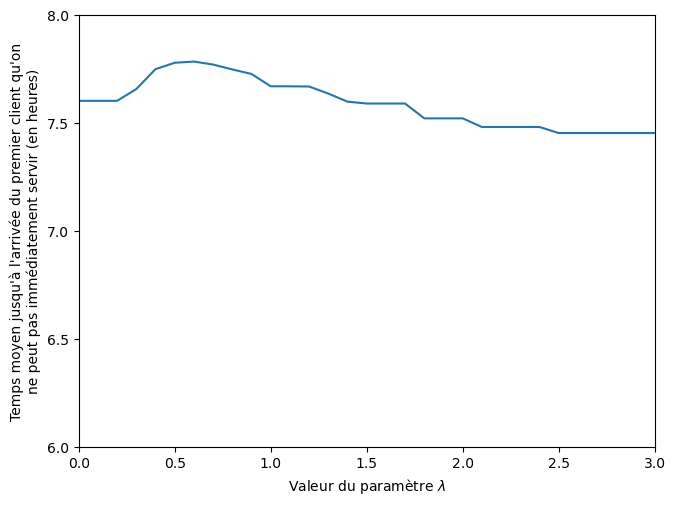

In [855]:
fig = plt.figure()
ax = fig.add_axes(rect = [0.1, 0.1, 0.9, 0.9])

ax.plot(lbdArray, tabTErr)

ax.set_ylabel("Temps moyen jusqu'à l'arrivée du premier client qu'on\nne peut pas immédiatement servir (en heures)")
ax.set_xlabel("Valeur du paramètre $\lambda$")
ax.set_xlim([0, 3])
ax.set_ylim([6, 8])
ax.set_yticks(np.arange(6, 8.5, 0.5))

fig.show()

### Graphiques pour indice multiplicatif ajusté

In [ ]:
nTenders = 20
nFiles = 3
d = 2
listeEtat = listAllStations(nTenders, nFiles, d)
retrait = lambda x : donGloutonSimplifie(x, d)
charge = lambda x : chargeSimplifie(x, d)
theta = 5/6

lbdArray = np.arange(0, 2.1, 0.2)
tabTErr = []

for lbd in lbdArray :
    indice = lambda x : indiceMultiplicatifCorr(x, lbd, d)
    ajout = lambda x : rangementIndiceSimplifie(x, indice)
    M = createTransitionMatrix(listeEtat, ajout, retrait, charge, theta)
    
    etatDepart = [[(nTenders // (nFiles - 1)) + 1, nCharge]] * (nTenders % (nFiles - 1))
    etatDepart += [[(nTenders // (nFiles - 1)), nCharge]] * (nFiles - 1 - (nTenders % (nFiles - 1)))
    etatDepart += [[0, 0]]
    etatDepart = np.array(etatDepart)
    
    etatArrivee = False
    
    i = 0
    j = 0

    while not np.array(listeEtat[i] == etatDepart).all() :
        i += 1

    while not np.array(listeEtat[j] == etatArrivee).all() :
        j += 1
    
    tabTErr.append(expectedHittingTime(M, i, j)[0])

print(tabTErr)

In [ ]:
np.savetxt('indiceMultCorr.csv',
            [(lbdArray[i], tabTErr[i]) for i in range(len(tabTErr))],
            delimiter = ',',
            fmt = ['%f', '%f'])

In [ ]:
fig = plt.figure()
ax = fig.add_axes(rect = [0.1, 0.1, 0.9, 0.9])

ax.plot(lbdArray[::1], tabTErr[::1])

ax.set_ylabel("Temps moyen jusqu'à l'arrivée du premier client qu'on\nne peut pas immédiatement servir (en heures)")
ax.set_xlabel("Valeur du paramètre $\lambda$")
ax.set_xlim([0, 2])
ax.set_ylim([6, 8])
ax.set_yticks(np.arange(6, 8.5, 0.5))

fig.show()

### Graphiques pour indice puissance-logarithme

In [ ]:
nTenders = 20
nFiles = 3
d = 2
listeEtat = listAllStations(nTenders, nFiles, d)
retrait = lambda x : donGloutonSimplifie(x, d)
charge = lambda x : chargeSimplifie(x, d)
theta = 5/6

etatDepart = [[(nTenders // (nFiles - 1)) + 1, nCharge]] * (nTenders % (nFiles - 1))
etatDepart += [[(nTenders // (nFiles - 1)), nCharge]] * (nFiles - 1 - (nTenders % (nFiles - 1)))
etatDepart += [[0, 0]]
etatDepart = np.array(etatDepart)

etatArrivee = False

i = 0
j = 0

while not np.array(listeEtat[i] == etatDepart).all() :
    i += 1

while not np.array(listeEtat[j] == etatArrivee).all() :
    j += 1

In [ ]:
# On fractionne le calcul en deux et on change lambda à la main (valeurs : 0.2, 1/3, 0.5, 1, 2, 3)
# pour diviser le calcul en plusieurs calculs plus courts

lbd = 1/5

tempTab = []
muArray = np.arange(0, 1, 0.1).tolist()

for mu in muArray :
    indice = lambda x : indicePuisLog(x, lbd, mu)
    ajout = lambda x : rangementIndiceSimplifie(x, indice)
    M = createTransitionMatrix(listeEtat, ajout, retrait, charge, theta)

    tempTab.append(expectedHittingTime(M, i, j)[0])

tabTErr.append(tempTab)

In [ ]:
lbd = 1/5

tempTab = []
muArray = np.arange(1, 11, 1).tolist()

for mu in muArray :
    indice = lambda x : indicePuisLog(x, lbd, mu)
    ajout = lambda x : rangementIndiceSimplifie(x, indice)
    M = createTransitionMatrix(listeEtat, ajout, retrait, charge, theta)

    tempTab.append(expectedHittingTime(M, i, j)[0])

tabTErr[-1] = tabTErr[-1] + tempTab

In [ ]:
fig = plt.figure()
ax = fig.add_axes(rect = [0.1, 0.1, 0.9, 0.9])

ax.plot(np.arange(0, 1, 0.1).tolist() + np.arange(1, 11, 1).tolist(), np.array(tabTErr).transpose())

fig.show()

In [ ]:
muArray = np.arange(0, 1, 0.1).tolist() + np.arange(1, 11, 1).tolist()

np.savetxt('indicePuisLog.csv',
            [tuple([muArray[i]]) +tuple(np.array(tabTErr).transpose()[i]) for i in range(len(muArray))],
            delimiter = ',',
            fmt = ['%f'] * (len(tabTErr) + 1))

### Graphiques pour indice puissance-log inversés

In [ ]:
nTenders = 20
nFiles = 3
d = 2
listeEtat = listAllStations(nTenders, nFiles, d)
retrait = lambda x : donGloutonSimplifie(x, d)
charge = lambda x : chargeSimplifie(x, d)
theta = 5/6

etatDepart = [[(nTenders // (nFiles - 1)) + 1, nCharge]] * (nTenders % (nFiles - 1))
etatDepart += [[(nTenders // (nFiles - 1)), nCharge]] * (nFiles - 1 - (nTenders % (nFiles - 1)))
etatDepart += [[0, 0]]
etatDepart = np.array(etatDepart)

etatArrivee = False

i = 0
j = 0

while not np.array(listeEtat[i] == etatDepart).all() :
    i += 1

while not np.array(listeEtat[j] == etatArrivee).all() :
    j += 1
    
tabTErr = []

In [ ]:
# On fractionne le calcul en deux et on change lambda à la main (valeurs : 0.2, 1/3, 0.5, 1, 2, 3)
# pour diviser le calcul en plusieurs calculs plus courts

lbd = 3

tempTab = []
muArray = np.arange(0, 1, 0.1).tolist()

for mu in muArray :
    indice = lambda x : indicePuisLogCorr(x, lbd, mu, d)
    ajout = lambda x : rangementIndiceSimplifie(x, indice)
    M = createTransitionMatrix(listeEtat, ajout, retrait, charge, theta)

    tempTab.append(expectedHittingTime(M, i, j)[0])

tabTErr.append(tempTab)

In [ ]:
lbd = 3

tempTab = []
muArray = np.arange(1, 11, 1).tolist()

for mu in muArray :
    indice = lambda x : indicePuisLogCorr(x, lbd, mu, d)
    ajout = lambda x : rangementIndiceSimplifie(x, indice)
    M = createTransitionMatrix(listeEtat, ajout, retrait, charge, theta)

    tempTab.append(expectedHittingTime(M, i, j)[0])

tabTErr[-1] = tabTErr[-1] + tempTab

In [ ]:
fig = plt.figure()
ax = fig.add_axes(rect = [0.1, 0.1, 0.9, 0.9])

ax.plot(np.arange(0, 1, 0.1).tolist() + np.arange(1, 11, 1).tolist(), np.array(tabTErr).transpose())

fig.show()

In [ ]:
muArray = np.arange(0, 1, 0.1).tolist() + np.arange(1, 11, 1).tolist()

np.savetxt('indicePuisLogInv.csv',
            [tuple([muArray[i]]) +tuple(np.array(tabTErr).transpose()[i]) for i in range(len(muArray))],
            delimiter = ',',
            fmt = ['%f'] * (len(tabTErr) + 1))

### Indices puissance

In [ ]:
nTenders = 20
nFiles = 3
d = 2
listeEtat = listAllStations(nTenders, nFiles, d)
retrait = lambda x : donGloutonSimplifie(x, d)
charge = lambda x : chargeSimplifie(x, d)
theta = 5/6

etatDepart = [[(nTenders // (nFiles - 1)) + 1, nCharge]] * (nTenders % (nFiles - 1))
etatDepart += [[(nTenders // (nFiles - 1)), nCharge]] * (nFiles - 1 - (nTenders % (nFiles - 1)))
etatDepart += [[0, 0]]
etatDepart = np.array(etatDepart)

etatArrivee = False

i = 0
j = 0

while not np.array(listeEtat[i] == etatDepart).all() :
    i += 1

while not np.array(listeEtat[j] == etatArrivee).all() :
    j += 1
    
tabTErr = []

In [ ]:
# On fractionne le calcul en deux et on change lambda à la main (valeurs : 0.2, 1/3, 0.5, 1, 2, 3)
# pour diviser le calcul en plusieurs calculs plus courts

lbd = 3

tempTab = []
muArray = np.arange(0, 1, 0.1).tolist()

for mu in muArray :
    indice = lambda x : indicePuis(x, lbd, mu)
    ajout = lambda x : rangementIndiceSimplifie(x, indice)
    M = createTransitionMatrix(listeEtat, ajout, retrait, charge, theta)

    tempTab.append(expectedHittingTime(M, i, j)[0])

tabTErr.append(tempTab)

In [ ]:
lbd = 3

tempTab = []
muArray = np.arange(1, 11, 1).tolist()

for mu in muArray :
    indice = lambda x : indicePuis(x, lbd, mu)
    ajout = lambda x : rangementIndiceSimplifie(x, indice)
    M = createTransitionMatrix(listeEtat, ajout, retrait, charge, theta)

    tempTab.append(expectedHittingTime(M, i, j)[0])

tabTErr[-1] = tabTErr[-1] + tempTab

In [ ]:
fig = plt.figure()
ax = fig.add_axes(rect = [0.1, 0.1, 0.9, 0.9])

ax.plot(np.arange(0, 1, 0.1).tolist() + np.arange(1, 11, 1).tolist(), np.array(tabTErr).transpose())

ax.set_xlim([0, 1])

fig.show()

In [ ]:
muArray = np.arange(0, 1, 0.1).tolist() + np.arange(1, 11, 1).tolist()

np.savetxt('indicePuis.csv',
            [tuple([muArray[i]]) +tuple(np.array(tabTErr).transpose()[i]) for i in range(len(muArray))],
            delimiter = ',',
            fmt = ['%f'] * (len(tabTErr) + 1))

### Indices puissance inversés

In [ ]:
nTenders = 20
nFiles = 3
d = 2
listeEtat = listAllStations(nTenders, nFiles, d)
retrait = lambda x : donGloutonSimplifie(x, d)
charge = lambda x : chargeSimplifie(x, d)
theta = 5/6

etatDepart = [[(nTenders // (nFiles - 1)) + 1, nCharge]] * (nTenders % (nFiles - 1))
etatDepart += [[(nTenders // (nFiles - 1)), nCharge]] * (nFiles - 1 - (nTenders % (nFiles - 1)))
etatDepart += [[0, 0]]
etatDepart = np.array(etatDepart)

etatArrivee = False

i = 0
j = 0

while not np.array(listeEtat[i] == etatDepart).all() :
    i += 1

while not np.array(listeEtat[j] == etatArrivee).all() :
    j += 1
    
tabTErr = []

In [ ]:
# On fractionne le calcul en deux et on change lambda à la main (valeurs : 0.2, 1/3, 0.5, 1, 2, 3)
# pour diviser le calcul en plusieurs calculs plus courts

lbd = 3

tempTab = []
muArray = np.arange(0, 1, 0.1).tolist()

for mu in muArray :
    indice = lambda x : indicePuisCorr(x, lbd, mu, d)
    ajout = lambda x : rangementIndiceSimplifie(x, indice)
    M = createTransitionMatrix(listeEtat, ajout, retrait, charge, theta)

    tempTab.append(expectedHittingTime(M, i, j)[0])

tabTErr.append(tempTab)

In [ ]:
lbd = 3

tempTab = []
muArray = np.arange(1, 11, 1).tolist()

for mu in muArray :
    indice = lambda x : indicePuisCorr(x, lbd, mu, d)
    ajout = lambda x : rangementIndiceSimplifie(x, indice)
    M = createTransitionMatrix(listeEtat, ajout, retrait, charge, theta)

    tempTab.append(expectedHittingTime(M, i, j)[0])

tabTErr[-1] = tabTErr[-1] + tempTab

In [ ]:
fig = plt.figure()
ax = fig.add_axes(rect = [0.1, 0.1, 0.9, 0.9])

ax.plot(np.arange(0, 1, 0.1).tolist() + np.arange(1, 11, 1).tolist(), np.array(tabTErr).transpose())

ax.set_xlim([0, 1])

fig.show()

In [ ]:
muArray = np.arange(0, 1, 0.1).tolist() + np.arange(1, 11, 1).tolist()

np.savetxt('indicePuisCorr.csv',
            [tuple([muArray[i]]) +tuple(np.array(tabTErr).transpose()[i]) for i in range(len(muArray))],
            delimiter = ',',
            fmt = ['%f'] * (len(tabTErr) + 1))

### Sensibilité à une méspécification des paramètres

In [871]:
tabIndices = []

nTenders = 20
nFiles = 3
d = 2
listeEtat = listAllStations(nTenders, nFiles, d)
retrait = lambda x : donGloutonSimplifie(x, d)
charge = lambda x : chargeSimplifie(x, d)

rhoArray = [1/2, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 30]
thetaArray = [rho / (rho + 1) for rho in rhoArray]

indice = lambda x : indiceLineaire(x, 30)
tabIndices.append(indice)

indice = lambda x : indiceLineaire(x, 7)
tabIndices.append(indice)

indice = lambda x : indiceLogarithmique(x, 3.5)
tabIndices.append(indice)

indice = lambda x : indiceMultiplicatif(x, 0.6)
tabIndices.append(indice)

indice = lambda x : indicePuis(x, 0.5, 0.1)
tabIndices.append(indice)

indice = lambda x : indicePuisCorr(x, 3, 0.2, d)
tabIndices.append(indice)

indice = lambda x : indicePuisLog(x, 0.2, 0.1)
tabIndices.append(indice)

indice = lambda x : indicePuisLogCorr(x, 3, 0.9, d)
tabIndices.append(indice)

tabTErr = []

In [872]:
etatDepart = [[(nTenders // (nFiles - 1)) + 1, nCharge]] * (nTenders % (nFiles - 1))
etatDepart += [[(nTenders // (nFiles - 1)), nCharge]] * (nFiles - 1 - (nTenders % (nFiles - 1)))
etatDepart += [[0, 0]]
etatDepart = np.array(etatDepart)

etatArrivee = False

i = 0
j = 0

while not np.array(listeEtat[i] == etatDepart).all() :
    i += 1

while not np.array(listeEtat[j] == etatArrivee).all() :
    j += 1

In [899]:
indexTheta = 13
theta = thetaArray[indexTheta]

tempTab = []
for indice in tabIndices :
    ajout = lambda x : rangementIndiceSimplifie(x, indice)
    M = createTransitionMatrix(listeEtat, ajout, retrait, charge, theta)
    tempTab.append(expectedHittingTime(M, i, j)[0])

tabTErr.append(tempTab)

In [ ]:
x = tabTErr[8]

In [901]:
[np.sign(x[1:] - x[0]) for x in tabTErr]

[array([-1., -1., -1., -1., -1., -1., -1.]),
 array([ 1.,  1.,  1., -1., -1., -1.,  1.]),
 array([ 1.,  1.,  1.,  1.,  1., -1.,  1.]),
 array([ 1.,  1.,  1.,  1.,  1., -1.,  1.]),
 array([1., 1., 1., 1., 1., 1., 1.]),
 array([1., 1., 1., 1., 1., 1., 1.]),
 array([1., 1., 1., 1., 1., 1., 1.]),
 array([1., 1., 1., 1., 1., 1., 1.]),
 array([1., 1., 1., 1., 1., 1., 1.]),
 array([1., 1., 1., 1., 1., 1., 1.]),
 array([1., 1., 1., 1., 1., 1., 1.]),
 array([-1.,  1.,  1., -1.,  1.,  1.,  1.]),
 array([-1., -1., -1., -1., -1.,  1., -1.]),
 array([-1., -1., -1., -1., -1., -1., -1.])]

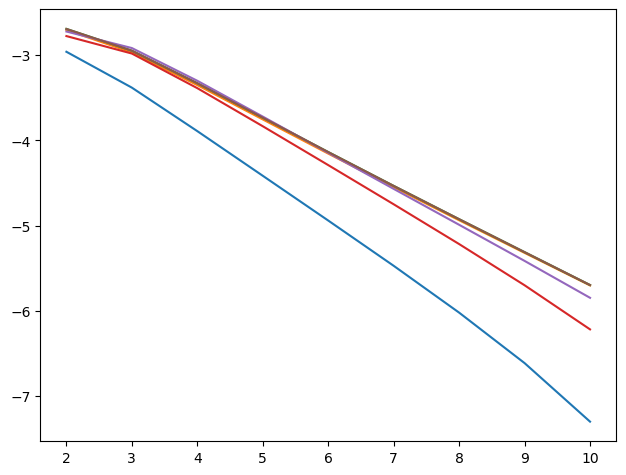

In [906]:
fig = plt.figure()
ax = fig.add_axes(rect = [0.1, 0.1, 0.9, 0.9])

ax.plot(rhoArray[2:11], [np.log(abs(x[1:] - x[0]) / x[0]) for x in [y[:6] + y[7:] for y in tabTErr[2:11]]])

fig.show()

In [908]:
np.savetxt('algRobusteNice.csv',
           [tuple([rhoArray[2:11][i]]) + tuple([100 * abs(x[1:] - x[0]) / x[0] for x in [y[:6] + y[7:] for y in tabTErr[2:11]]][i]) for i in range(9)],
            delimiter = ',',
            fmt = ['%f'] * (len(tabTErr[0]) - 1))

In [903]:
np.savetxt('algRobuste.csv',
            [tuple([rhoArray[i]]) +tuple(np.array(tabTErr)[i]) for i in range(len(rhoArray))],
            delimiter = ',',
            fmt = ['%f'] * (len(tabTErr[0]) + 1))